# Forecasting: Principles and Practice

## Introduction

Having gone through 'Principles and Practice' using R, I intend to do a second pass through the book using Python this time.

In this notebook, I've explored using both Pandas and Polars, as well as the graphics libraries matplotlib, seaborn, and plotly express.

# Chapter 2

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns
import statsmodels.api as sm

warnings.filterwarnings("ignore")

## Exercise 3

In [2]:
sales_data = pd.read_csv("data/tute1.csv", index_col=0, parse_dates=["Quarter"])
sales_data.head()

Sales  AdBudget    GDP
Quarter                            
1981-03-01  1020.2     659.2  251.8
1981-06-01   889.2     589.0  290.9
1981-09-01   795.0     512.5  290.8
1981-12-01  1003.9     614.1  292.4
1982-03-01  1057.7     647.2  279.1

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 1981-03-01 to 2005-12-01
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     100 non-null    float64
 1   AdBudget  100 non-null    float64
 2   GDP       100 non-null    float64
dtypes: float64(3)
memory usage: 3.1 KB


### c Construct time series plots of each of the three series

array([<Axes: xlabel='Quarter'>, <Axes: xlabel='Quarter'>,
       <Axes: xlabel='Quarter'>], dtype=object)

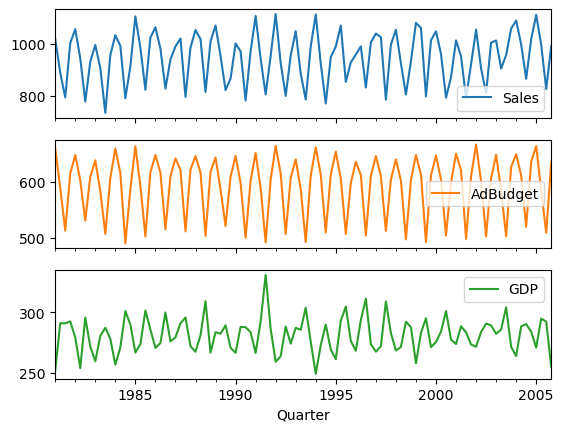

In [4]:
sales_data.plot(subplots=True)

### Exercise 4

In [5]:
us_gas_ts = pd.read_csv(
    "data/us_total.csv", skiprows=[0], names=["Year", "State", "Gas"]
)
us_gas_ts

Year    State     Gas
0     1997  Alabama  324158
1     1998  Alabama  329134
2     1999  Alabama  337270
3     2000  Alabama  353614
4     2001  Alabama  332693
...    ...      ...     ...
1261  2015  Wyoming  119265
1262  2016  Wyoming  123351
1263  2017  Wyoming  149405
1264  2018  Wyoming  165384
1265  2019  Wyoming  154836

[1266 rows x 3 columns]

### c Plot the annual natural gas consumption by state for the New England area (comprising the states of Maine, Vermont, New Hampshire, Massachusetts, Connecticut and Rhode Island).

In [6]:
us_gas_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    1266 non-null   int64 
 1   State   1266 non-null   object
 2   Gas     1266 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 29.8+ KB


In [7]:
new_england_gas_ts = us_gas_ts.query(
    'State in ["Maine","Vermont","New Hampshire", "Massachusetts", "Connecticut", "Rhode Island"]'
).assign(Gas=us_gas_ts["Gas"] / 1000)
new_england_gas_ts

Year        State      Gas
138   1997  Connecticut  144.708
139   1998  Connecticut  131.497
140   1999  Connecticut  152.237
141   2000  Connecticut  159.712
142   2001  Connecticut  146.278
...    ...          ...      ...
1146  2015      Vermont   11.950
1147  2016      Vermont   12.094
1148  2017      Vermont   11.926
1149  2018      Vermont   13.742
1150  2019      Vermont   13.866

[138 rows x 3 columns]

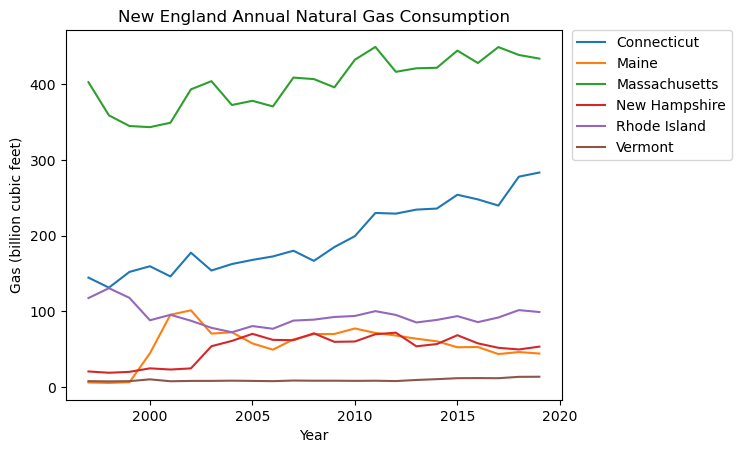

In [8]:
ax = sns.lineplot(data=new_england_gas_ts, x="Year", y="Gas", hue="State")
ax.set(
    title="New England Annual Natural Gas Consumption",
    ylabel="Gas (billion cubic feet)",
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

## Exercise 5

The Tourism data contains numerous time series. One for each region in a state and for various purposes. I initially tried plotting the data, but all I could see was a confusing mess. Now I now the reason why!

In [9]:
tourism_data = pd.read_excel(
    "data/tourism.xlsx",
    names=["Date", "Region", "State", "Purpose", "Trips"],
    parse_dates=["Date"],
)
tourism_data.head()

Date    Region            State   Purpose       Trips
0 1998-01-01  Adelaide  South Australia  Business  135.077690
1 1998-04-01  Adelaide  South Australia  Business  109.987316
2 1998-07-01  Adelaide  South Australia  Business  166.034687
3 1998-10-01  Adelaide  South Australia  Business  127.160464
4 1999-01-01  Adelaide  South Australia  Business  137.448533

### Find what combination of Region and Purpose had the maximum number of overnight trips on average.

Maximum number of overnight trips on average by region

In [10]:
(
    tourism_data.groupby(
        [
            "Region",
            "State",
            "Purpose",
        ]
    )
    .pipe(lambda x: x.Trips.mean())
    .reset_index()
    .sort_values("Trips", ascending=False)
    .head()
)

Region            State   Purpose       Trips
271           Sydney  New South Wales  Visiting  747.269968
199        Melbourne         Victoria  Visiting  618.897541
268           Sydney  New South Wales  Business  602.043884
217  North Coast NSW  New South Wales   Holiday  587.896632
269           Sydney  New South Wales   Holiday  550.326865

Maximum number of quarterly overnight trips on average by state

In [11]:
(
    tourism_data.assign(Quarter=tourism_data["Date"].dt.to_period("Q"))
    .groupby(["State", "Purpose", "Quarter"])
    .pipe(lambda x: x.Trips.mean())
    .reset_index()
    .sort_values("Trips", ascending=False)
    .head()
)

State   Purpose Quarter       Trips
400  New South Wales   Holiday  1998Q1  310.223833
472  New South Wales   Holiday  2016Q1  299.836492
128              ACT   Holiday  2010Q1  299.831282
319              ACT  Visiting  2017Q4  287.966424
440  New South Wales   Holiday  2008Q1  281.140678

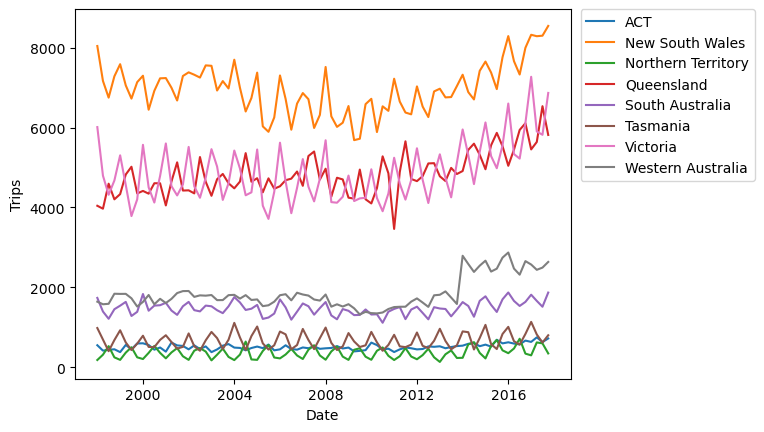

In [12]:
state_quarter_ts = tourism_data.groupby(["State", "Date"]).sum()

ax = sns.lineplot(data=state_quarter_ts, x="Date", y="Trips", hue="State")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

### d Create a new tsibble which combines the Purposes and Regions, and just has total trips by State.

In [13]:
(
    tourism_data.groupby(["State"])
    .pipe(lambda x: round(x.Trips.sum()))
    .reset_index()
    .set_index("State")
    .rename(columns={"Trips": "Total Trips"})
    .sort_values("Total Trips", ascending=False)
)

Total Trips
State                          
New South Wales        557367.0
Victoria               390463.0
Queensland             386643.0
Western Australia      147820.0
South Australia        118151.0
Tasmania                54137.0
ACT                     41007.0
Northern Territory      28614.0

## Exercise 6

The aus_arrivals data set comprises quarterly international arrivals to Australia from Japan, New Zealand, UK and the US.

Use autoplot(), gg_season() and gg_subseries() to compare the differences between the arrivals from these four countries.

In [14]:
aus_arrivals_ts = pd.read_csv("data/aus_arrivals.csv", index_col=0)

In [15]:
aus_arrivals_wide_ts = aus_arrivals_ts.assign(
    Arrivals=aus_arrivals_ts["Arrivals"] / 1000
).pivot(columns="Origin", values="Arrivals")
aus_arrivals_wide_ts

Origin     Japan       NZ       UK       US
Quarter                                    
1981 Q1   14.763   49.140   45.266   32.316
1981 Q2    9.321   87.467   19.886   23.721
1981 Q3   10.166   85.841   24.839   24.533
1981 Q4   19.509   61.882   52.264   33.438
1982 Q1   17.117   42.045   53.636   33.527
...          ...      ...      ...      ...
2011 Q3   96.467  311.994  107.089  101.925
2011 Q4   89.900  329.470  202.240  127.150
2012 Q1   98.180  247.910  194.640  129.520
2012 Q2   59.760  301.880   92.970  105.700
2012 Q3  101.900  319.840  101.690  106.540

[127 rows x 4 columns]

[Text(0.5, 1.0, 'Austrialian Quarterly International Arrivals'),
 Text(0, 0.5, "Arrivals ('000s)")]

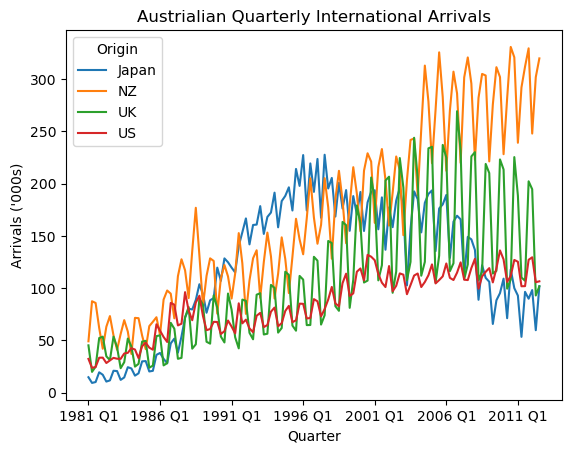

In [16]:
ax = aus_arrivals_wide_ts.plot()
ax.set(title="Austrialian Quarterly International Arrivals", ylabel="Arrivals ('000s)")

Now, using Seaborn.

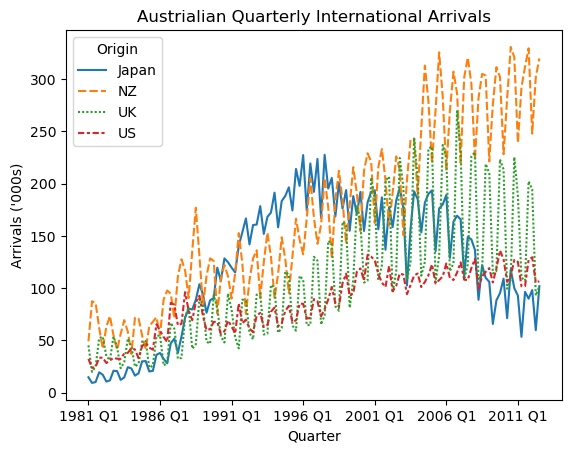

In [17]:
ax = sns.lineplot(data=aus_arrivals_wide_ts)
ax.set(title="Austrialian Quarterly International Arrivals", ylabel="Arrivals ('000s)")
plt.xticks(range(0, 140, 20));

Using Plotly Express. One big advantage with Express is that you can interact with the plot.

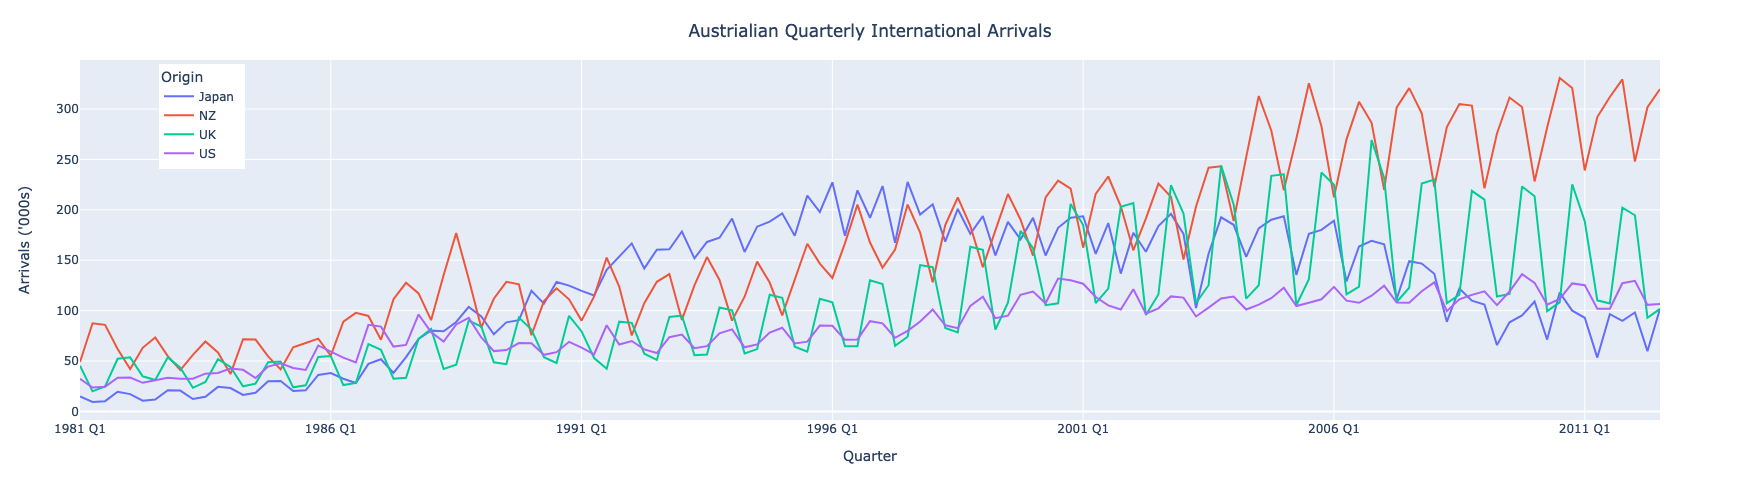

In [18]:
fig = px.line(aus_arrivals_wide_ts, height=500, width=600)
fig.update_layout(
    title=dict(
        text="Austrialian Quarterly International Arrivals",
        y=0.95,
        x=0.5,
        xanchor="center",
        yanchor="top",
    ),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.05),
    yaxis_title="Arrivals ('000s)",
    xaxis=dict(tickmode="linear", tick0=0, dtick=20),
)
fig.show()

Using code from zgana, see [fpp3-python-readalong/02-Time-series-graphics.ipynb]()

In [19]:
def seasonalize(data, column, period="year"):
    if period.lower() in ("year", "y"):
        d = data.assign(__period=data.index.year, __x=data.index.dayofyear)
    elif period.lower() in ("week", "w"):
        d = data.assign(
            __period=100 * data.index.year + data.index.week,
            __x=data.index.dayofweek
            + (data.index.hour + data.index.minute / 60 + data.index.second / 3600)
            / 24,
        )
    elif period.lower() in ("day", "d"):
        d = data.assign(
            __period=data.index.date,
            __x=data.index.hour + data.index.minute / 60 + data.index.second / 3600,
        )
    d = (
        d.sort_values("__x")
        .groupby("__period")
        .pipe(summarize, lambda x: {"time": list(x.__x), column: list(x[column])})
    )
    return d


def plot_seasonal(
    data, column, period="year", cmap="viridis", labels="", figsize=None, ax=None, **kw
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = ax.figure, ax
    d = seasonalize(data, column, period)
    cm = plt.get_cmap(cmap)
    for i, p in enumerate(d.index):
        color = cm(i / len(d))
        x, y = d.time.loc[p], d[column].loc[p]
        ax.plot(x, y, color=color, label=str(p), **kw)
        if labels in "right both".split():
            ax.text(x[-1], y[-1], str(p), color=color, ha="center", va="center")
        if labels in "left both".split():
            ax.text(x[0], y[0], str(p), color=color, ha="center", va="center")
    return ax


def suptitle(fig, text=None, **kw):
    """Add a nice left-aligned suptitle."""
    if text is None:
        fig, text = plt.gcf(), fig
    fig = fig.figure or fig
    fig.text(fig.subplotpars.left, 0.99, text, ha="left", va="top", size="large", **kw)


def summarize(gb, f):
    """Summarize grouped things."""
    return gb.apply(lambda x: pd.Series(f(x)))

To use zgana's code directly, I needed to change the quarterly data to use a datetime instead.

In [38]:
aus_arrivals_ts.head()

Origin  Arrivals
Quarter                 
1981 Q1  Japan     14763
1981 Q2  Japan      9321
1981 Q3  Japan     10166
1981 Q4  Japan     19509
1982 Q1  Japan     17117

In [39]:
aus_arrivals_ts2 = aus_arrivals_ts.reset_index()
my_ts = (
    aus_arrivals_ts2.assign(
        Date=aus_arrivals_ts2["Quarter"].str.replace(" ", "-").pipe(pd.to_datetime)
    )
    .drop("Quarter", axis=1)
    .set_index("Date")
)
my_ts.head()

Origin  Arrivals
Date                       
1981-01-01  Japan     14763
1981-04-01  Japan      9321
1981-07-01  Japan     10166
1981-10-01  Japan     19509
1982-01-01  Japan     17117

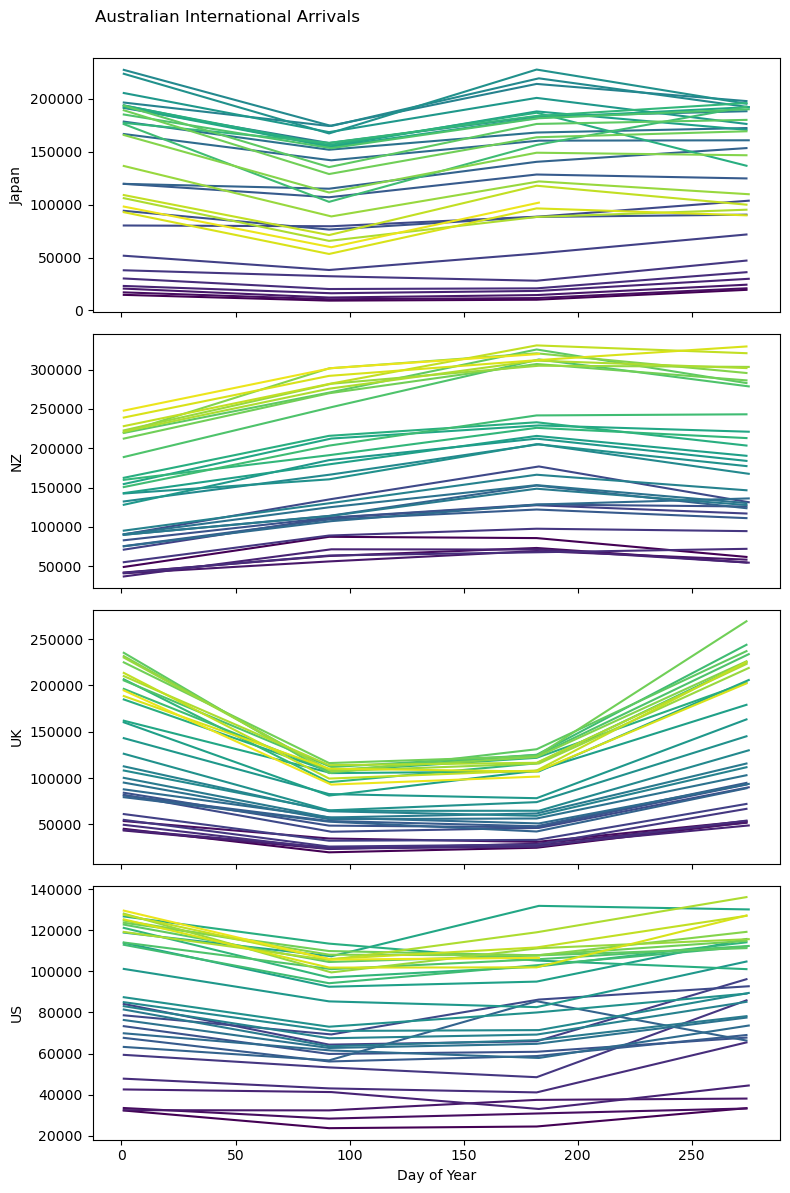

In [40]:
fig, axs = plt.subplots(my_ts.Origin.nunique(), 1, figsize=(8, 12), sharex=True)
for ax, (Origin, d) in zip(axs, my_ts.groupby("Origin")):
    plot_seasonal(d, "Arrivals", ax=ax)
    ax.set(ylabel=Origin)
ax.set(xlabel="Day of Year")
suptitle("Australian International Arrivals")
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Exercise 10

The aus_livestock data contains the monthly total number of pigs slaughtered in Victoria, Australia, from Jul 1972 to Dec 2018. Use filter() to extract pig slaughters in Victoria between 1990 and 1995. Use autoplot() and ACF() for this data. How do they differ from white noise? If a longer period of data is used, what difference does it make to the ACF?

In [23]:
aus_livestock = pl.read_csv("data/aus_livestock.csv", infer_schema_length=1000)
aus_livestock.head()

shape: (5, 4)
┌──────────┬────────────────────────────┬──────────────────────────────┬────────┐
│ Month    ┆ Animal                     ┆ State                        ┆ Count  │
│ ---      ┆ ---                        ┆ ---                          ┆ ---    │
│ str      ┆ str                        ┆ str                          ┆ f64    │
╞══════════╪════════════════════════════╪══════════════════════════════╪════════╡
│ 1976 Jul ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2300.0 │
│ 1976 Aug ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
│ 1976 Sep ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
│ 1976 Oct ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 1900.0 │
│ 1976 Nov ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
└──────────┴────────────────────────────┴──────────────────────────────┴────────┘

In [24]:
aus_livestock.glimpse()

Rows: 29364
Columns: 4
$ Month  <str> '1976 Jul', '1976 Aug', '1976 Sep', '1976 Oct', '1976 Nov', '1976 Dec', '1977 Jan', '1977 Feb', '1977 Mar', '1977 Apr'
$ Animal <str> 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers', 'Bulls, bullocks and steers'
$ State  <str> 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory', 'Australian Capital Territory'
$ Count  <f64> 2300.0, 2100.0, 2100.0, 1900.0, 2100.0, 1800.0, 1800.0, 1900.0, 2700.0, 2300.0



In [50]:
livestock_ts = aus_livestock.rename({"Month": "Date"}).with_columns(
    pl.col("Date").str.to_date("%Y %b")
)
livestock_ts.head()

shape: (5, 4)
┌────────────┬────────────────────────────┬──────────────────────────────┬────────┐
│ Date       ┆ Animal                     ┆ State                        ┆ Count  │
│ ---        ┆ ---                        ┆ ---                          ┆ ---    │
│ date       ┆ str                        ┆ str                          ┆ f64    │
╞════════════╪════════════════════════════╪══════════════════════════════╪════════╡
│ 1976-07-01 ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2300.0 │
│ 1976-08-01 ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
│ 1976-09-01 ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
│ 1976-10-01 ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 1900.0 │
│ 1976-11-01 ┆ Bulls, bullocks and steers ┆ Australian Capital Territory ┆ 2100.0 │
└────────────┴────────────────────────────┴──────────────────────────────┴────────┘

In [44]:
pigs_slaughtered = (
    livestock_ts.filter(pl.col("Animal") == "Pigs")
    .filter(pl.col("State") == "Victoria")
    .filter(pl.col("Date").is_between(datetime(1990, 1, 1), datetime(1995, 12, 31)))
)

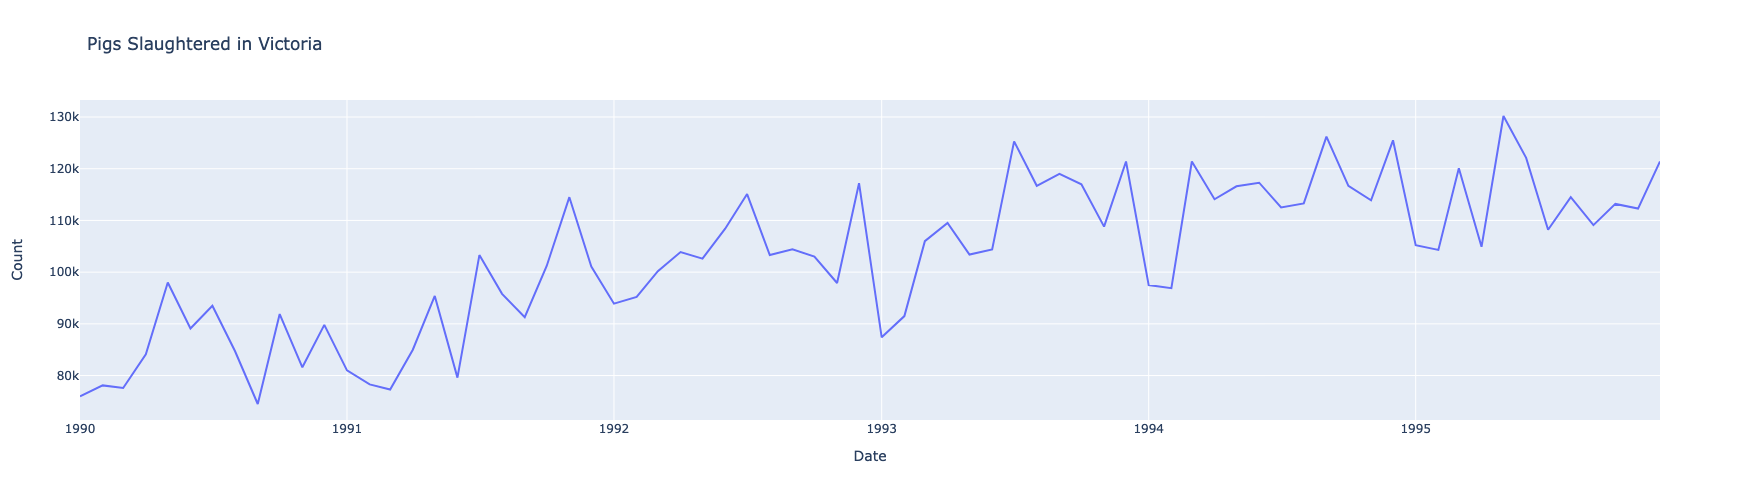

In [45]:
px.line(
    data_frame=pigs_slaughtered,
    x="Date",
    y="Count",
    height=500,
    width=600,
    title="Pigs Slaughtered in Victoria",
)

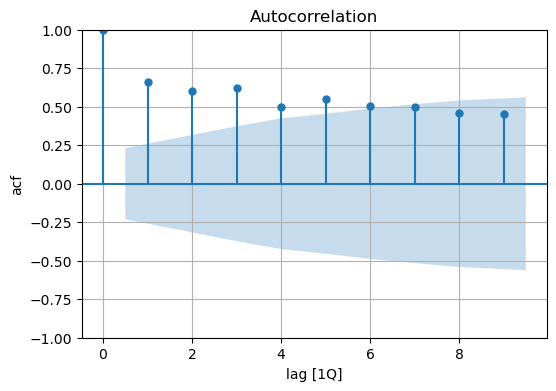

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.tsa.plot_acf(pigs_slaughtered["Count"], ax=ax, lags=9)
ax.set(ylim=(-1, 1), xlabel="lag [1Q]", ylabel="acf")
plt.grid()

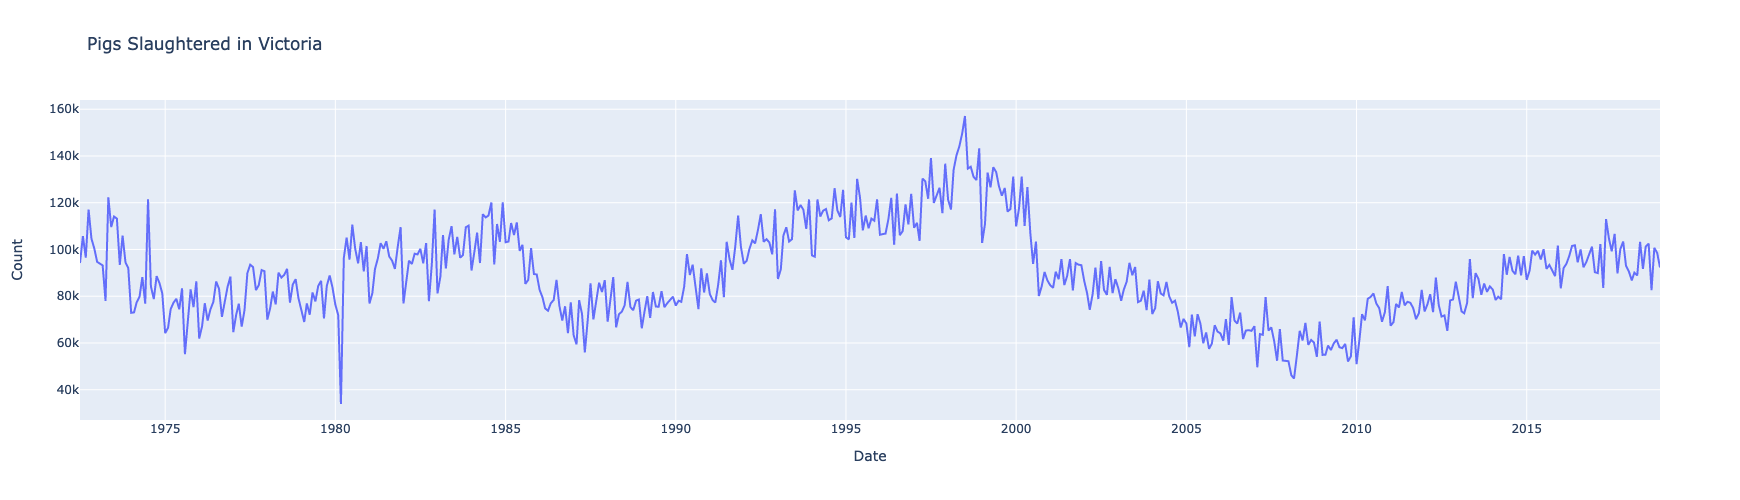

In [47]:
pigs_slaughtered_full = livestock_ts.filter(pl.col("Animal") == "Pigs").filter(
    pl.col("State") == "Victoria"
)

px.line(
    data_frame=pigs_slaughtered_full,
    x="Date",
    y="Count",
    height=500,
    width=600,
    title="Pigs Slaughtered in Victoria",
)

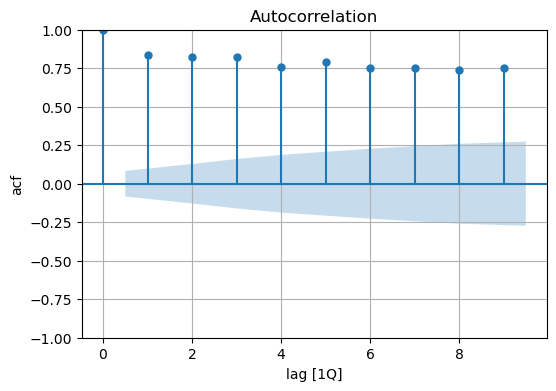

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.tsa.plot_acf(pigs_slaughtered_full["Count"], ax=ax, lags=9)
ax.set(ylim=(-1, 1), xlabel="lag [1Q]", ylabel="acf")
plt.grid()